In [3]:
import numpy as np
import networkx as nx
import os, time

import os.path as osp
import glob
from wmpgnn.datasets.graph_dataset import CustomDataset
from torch_geometric.loader import DataLoader
import contextlib
import torch
from torch import nn
from torch_scatter import scatter_add

In [71]:
#myModel._blocks[0]._network._node_block._sent_edges_aggregator._weighted


False

In [2]:
files_input_tr = sorted(glob.glob('cached_data/input_*'))[:10000]
files_target_tr = sorted(glob.glob('cached_data/target_*'))[:10000]


data_tr = CustomDataset(files_input_tr, files_target_tr)

In [4]:
#data_tr[1].edge_index

In [2]:
BATCH_SIZE = 32
loader_tr = DataLoader(data_tr, batch_size=BATCH_SIZE, drop_last=True)

NameError: name 'data_tr' is not defined

In [3]:
for b in loader_tr:
    break

NameError: name 'loader_tr' is not defined

In [24]:
b.edge_index

tensor([[   1,    2,    3,  ..., 4945, 4945, 4946],
        [   0,    0,    0,  ..., 4946, 4947, 4947]])

In [ ]:
files_input_tr = sorted(glob.glob('/home/sutclw/Work/Zurich/LHCb/GNNs/cached_LCA_training_events_PYTHIA/training_dataset/input_*'))
files_target_tr = sorted(glob.glob('/home/sutclw/Work/Zurich/LHCb/GNNs/cached_LCA_training_events_PYTHIA/training_dataset/target_*'))
data_tr = CustomDataset(files_input_tr, files_target_tr)
dataset_tr = data_tr.get()
print("finish loading training dataset")

files_input_vl = sorted(glob.glob('/home/sutclw/Work/Zurich/LHCb/GNNs/cached_LCA_training_events_PYTHIA/validation_dataset/input_*'))
files_target_vl = sorted(glob.glob('/home/sutclw/Work/Zurich/LHCb/GNNs/cached_LCA_training_events_PYTHIA/validation_dataset/target_*'))
data_vl = CustomDataset(files_input_vl, files_target_vl)
dataset_vl = data_vl.get()
print("finish loading validation dataset")

finish loading training dataset


In [3]:
files_input_tr[0]

'/home/sutclw/Work/Zurich/LHCb/GNNs/cached_LCA_training_events_PYTHIA/training_dataset/input_0.npy'

In [8]:
len(files_input_tr)

49399

In [ ]:
files_input_tr = sorted(glob.glob('cached_data/input_*'))[:40000]
files_target_tr = sorted(glob.glob('cached_data/target_*'))[:40000]


data_tr = CustomDataset(files_input_tr, files_target_tr)
dataset_tr = data_tr.get()
#print("finish loading training dataset")

files_input_vl = sorted(glob.glob('cached_data/input_*'))[40000:]
files_target_vl = sorted(glob.glob('cached_data/target_*'))[40000:]
data_vl = CustomDataset(files_input_vl, files_target_vl)
dataset_vl = data_vl.get()
print("finish loading validation dataset")

In [ ]:
NUM_LAYERS = 5
HIDDEN_CHANNELS=128

In [ ]:
BATCH_SIZE = 32
loader_tr = DataLoader(dataset_tr, batch_size=BATCH_SIZE, drop_last=True)
loader_vl = DataLoader(dataset_vl, batch_size=BATCH_SIZE, drop_last=True)

In [4]:
for vdata in loader_vl:
    break

In [7]:
32*(3018/32)**2

284635.125

In [8]:
vdata

DataBatch(y=[117026, 4], nodes=[3018, 10], edges=[117026, 4], senders=[117026], receivers=[117026], graph_globals=[32], edgepos=[117026], num_edges=[32], num_nodes=3018, batch=[3018], ptr=[33])

In [9]:
vdata

DataBatch(y=[117026, 4], nodes=[3018, 10], edges=[117026, 4], senders=[117026], receivers=[117026], graph_globals=[32], edgepos=[117026], num_edges=[32], num_nodes=3018, batch=[3018], ptr=[33])

In [ ]:

#from wmpgnn.model.gnn_model import EncodeProcessDecode

In [ ]:
#from importlib import reload
import wmpgnn.model.gnn_model

# Reload the module
#reload(wmpgnn.model.gnn_model)

# Import the updated EncodeProcessDecode
from wmpgnn.model.gnn_model import GNN


In [ ]:
from wmpgnn.util.functions import weight_four_class, acc_four_class

In [ ]:
weights=weight_four_class(loader_tr)

In [8]:
from wmpgnn.gnn.graph_network import GraphNetwork

In [9]:
#GraphNetwork(

In [10]:
#GraphNetwork(

In [20]:
MLP_OUTPUT_SIZE=16
myModel=GNN(mlp_output_size=MLP_OUTPUT_SIZE, edge_op=4, num_blocks=8,use_edge_weights=True, use_node_weights=True)

myModel.cuda()

optimizer = torch.optim.Adam(myModel.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=weights)
pos_weight = torch.tensor([166.128])  

criterionBCE = nn.BCELoss(weight=pos_weight) 
pos_weight = torch.tensor([15.5])
criterionBCEnodes = nn.BCELoss(weight=pos_weight) 
# criterionBCE = nn.BCELoss() 
# pos_weight = torch.tensor([15.5])
# criterionBCEnodes = nn.BCELoss() 
criterion.to('cuda')
criterionBCE.cuda()
criterionBCEnodes.cuda()

BCELoss()

In [21]:
add_BCE = True

In [22]:
from torch_geometric.nn.models import MLP
from torch.nn import Linear, Sigmoid, Softmax

In [23]:
sigmoid = Sigmoid()

def make_weight_mlp(output_size):
    return lambda: MLP(in_channels=-1, hidden_channels=16,
                       out_channels=output_size, num_layers=4 , norm=None)

mlp_nodes = make_weight_mlp(1)()
mlp_edges = make_weight_mlp(1)()
#mlp_nodes_ce = make_weight_mlp(4)()
mlp_edges_ce = make_weight_mlp(4)()

In [24]:
mlp_edges.cuda()
mlp_nodes.cuda()
mlp_edges_ce.cuda()

MLP(-1, 16, 16, 16, 4)

In [25]:
last_batch = len(loader_tr)

def train_one_epoch(epoch_index):
    
    running_loss = 0.
    last_loss = 0.
    acc_one_epoch = []
    for i, data in enumerate(loader_tr): 
        data['graph_globals'] = data['graph_globals'].unsqueeze(1)
        data.receivers = data.receivers - torch.min(data.receivers)
        data.senders = data.senders - torch.min(data.senders)
        data.edgepos = data.edgepos - torch.min(data.edgepos)
        optimizer.zero_grad()
        #print(data)
        data.to('cuda')
        #print("shape before ", data.y.shape)
        yBCE_start = 1.*(data.y[:,0]==0).unsqueeze(1)
        num_nodes=data.nodes.shape[0]
        out = data.edges.new_zeros(num_nodes, data.edges.shape[1])
        node_sum = scatter_add(data.y,data.senders,out=out,dim=0)
        ynodes_start = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)
        label0 = data.y.argmax(dim=1)
        answers = torch.ones_like(data.edges).cuda()

        outputs = myModel(data)

        data = outputs


        label= data.y.argmax(dim=1)
        num_nodes=data.nodes.shape[0]
        out = data.edges.new_zeros(num_nodes, data.edges.shape[1])
        node_sum = scatter_add(data.y,data.senders,out=out,dim=0)
        ynodes = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)


        loss = criterion(outputs.edges, label) 
        yBCE = 1.*(data.y[:,0]==0).unsqueeze(1)
        if add_BCE:
           #loss += 0.2*criterionBCE(sigmoid(mlp_edges(outputs.edges)), yBCE)
            #loss += 0.2*criterionBCEnodes(sigmoid(mlp_nodes(outputs.nodes)), ynodes)
            count = 0 
            for block in myModel._blocks:
                #if count != 7: 
                #    loss += criterion(mlp_edges_ce(block._network.edges), label) 
                loss += 0.2*criterionBCE(block._network.edge_weights, yBCE)
                loss += 0.2*criterionBCEnodes(block._network.node_weights, ynodes)
                count += 1
    
        loss.backward()


        acc_one_batch = acc_four_class(outputs.edges, label)
        acc_one_epoch.append(acc_one_batch)

        optimizer.step()

        running_loss += loss.item()
        if (i+1) == last_batch:
            last_loss = running_loss / last_batch # loss per batch
            print('  batch {} last_batch {} loss: {}'.format(i + 1, last_batch, last_loss))

            running_loss = 0.
    
        
    acc_one_epoch=torch.stack(acc_one_epoch)

    return last_loss, acc_one_epoch.nanmean(dim=0)

In [26]:
last_batch_vl = len(loader_vl)

def eval_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    acc_one_epoch = []
    
    for j, vdata in enumerate(loader_vl): 

        vdata['graph_globals'] = vdata['graph_globals'].unsqueeze(1)
        vdata.receivers = vdata.receivers - torch.min(vdata.receivers)
        vdata.senders = vdata.senders - torch.min(vdata.senders)
        vdata.edgepos = vdata.edgepos - torch.min(vdata.edgepos)
        vdata.to('cuda')
        yBCE_start = 1.*(vdata.y[:,0]==0).unsqueeze(1)
        num_nodes=vdata.nodes.shape[0]
        out = vdata.edges.new_zeros(num_nodes, vdata.edges.shape[1])
        node_sum = scatter_add(vdata.y,vdata.senders,out=out,dim=0)
        ynodes_start = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)
        
        label0 = vdata.y.argmax(dim=1)
        answers = torch.ones_like(vdata.edges).cuda()

        outputs = myModel(vdata)

        vdata = outputs
        label= vdata.y.argmax(dim=1)

        num_nodes=vdata.nodes.shape[0]
        out = vdata.edges.new_zeros(num_nodes, vdata.edges.shape[1])
        node_sum = scatter_add(vdata.y,vdata.senders,out=out,dim=0)
        ynodes = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)

        loss = criterion(outputs.edges, label) 
        yBCE = 1.*(vdata.y[:,0]==0).unsqueeze(1)
        if add_BCE:
            #loss += 0.2*criterionBCE(sigmoid(mlp_edges(outputs.edges)), yBCE)
            #loss += 0.2*criterionBCEnodes(sigmoid(mlp_nodes(outputs.nodes)), ynodes)
            count = 0 
            for block in myModel._blocks:
                #if count != 7: 
                #    loss += criterion(mlp_edges_ce(block._network.edges), label) 
                loss += 0.2*criterionBCE(block._network.edge_weights, yBCE)
                loss += 0.2*criterionBCEnodes(block._network.node_weights, ynodes)
                count += 1

        #if myModel._blocks[3]._network.edge_prune:

        acc_one_batch = acc_four_class(outputs.edges, label)
        acc_one_epoch.append(acc_one_batch)
#         break
        # Gather data and report
        running_loss += loss.item()
        if (j+1) == last_batch_vl:
            last_loss = running_loss / last_batch_vl # loss per batch
            print(' validation: batch {} last_batch {} loss: {}'.format(j + 1, last_batch_vl, last_loss))
            running_loss = 0.
    
    acc_one_epoch=torch.stack(acc_one_epoch)

    return last_loss, acc_one_epoch.nanmean(dim=0)

In [27]:
STEP_SIZE = 2

lst_tr_loss = []
lst_vl_loss = []

lst_vl_acc = []
lst_tr_acc = []
start = time.time()

epoch_number = 0

EPOCHS = 30

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print("epoch no. ", (epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    myModel.train(True)
    tr_loss, tr_acc= train_one_epoch(epoch_number)
    lst_tr_loss.append(tr_loss)
    lst_tr_acc.append(tr_acc)
#     break
    # We don't need gradients on to do reporting
    myModel.train(False)
    vl_loss, vl_acc= eval_one_epoch(epoch_number)
    lst_vl_loss.append(vl_loss)
    lst_vl_acc.append(vl_acc)
    
    print(f'Train Loss: {tr_loss:03f}')
    print(f'Val Loss: {vl_loss:03f}')
    print(f'Train Acc: {tr_acc}')
    print(f'Val Acc: {vl_acc}')
    epoch_number += 1
    

end = time.time()

epoch no.  1
  batch 1234 last_batch 1234 loss: 19.73090435542782
 validation: batch 290 last_batch 290 loss: 10.146211617568444
Train Loss: 19.730904
Val Loss: 10.146212
Train Acc: tensor([0.5456, 0.5364, 0.2008, 0.4009])
Val Acc: tensor([0.8605, 0.8802, 0.0954, 0.4129])
epoch no.  2
  batch 1234 last_batch 1234 loss: 9.269607177236672
 validation: batch 290 last_batch 290 loss: 8.331474649495092
Train Loss: 9.269607
Val Loss: 8.331475
Train Acc: tensor([0.8968, 0.6809, 0.3350, 0.4223])
Val Acc: tensor([0.9075, 0.7890, 0.3059, 0.4323])
epoch no.  3
  batch 1234 last_batch 1234 loss: 7.562707519608534
 validation: batch 290 last_batch 290 loss: 6.9769947331527185
Train Loss: 7.562708
Val Loss: 6.976995
Train Acc: tensor([0.9331, 0.6532, 0.3979, 0.5013])
Val Acc: tensor([0.9556, 0.7076, 0.3148, 0.6806])
epoch no.  4
  batch 1234 last_batch 1234 loss: 6.379329901846726
 validation: batch 290 last_batch 290 loss: 5.663989383598854
Train Loss: 6.379330
Val Loss: 5.663989
Train Acc: tensor(

In [ ]:
torch.ones((12,1))

In [ ]:
myModel._blocks[0]._network.edge_weights

In [ ]:
torch.ones_like(myModel._blocks[0]._network.edge_weights)

In [28]:
optimizer = torch.optim.Adam(myModel.parameters(), lr=0.0001)

epoch_number = 30

EPOCHS = 2

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print("epoch no. ", (epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    myModel.train(True)
    tr_loss, tr_acc= train_one_epoch(epoch_number)
    lst_tr_loss.append(tr_loss)
    lst_tr_acc.append(tr_acc)
#     break
    # We don't need gradients on to do reporting
    myModel.train(False)
    vl_loss, vl_acc= eval_one_epoch(epoch_number)
    lst_vl_loss.append(vl_loss)
    lst_vl_acc.append(vl_acc)
    
    print(f'Train Loss: {tr_loss:03f}')
    print(f'Val Loss: {vl_loss:03f}')
    print(f'Train Acc: {tr_acc}')
    print(f'Val Acc: {vl_acc}')
    
    epoch_number += 1

epoch no.  31
  batch 1234 last_batch 1234 loss: 3.3849346370132856
 validation: batch 290 last_batch 290 loss: 3.5542440825495225
Train Loss: 3.384935
Val Loss: 3.554244
Train Acc: tensor([0.9843, 0.7607, 0.5540, 0.8790])
Val Acc: tensor([0.9846, 0.7755, 0.5422, 0.8370])
epoch no.  32
  batch 1234 last_batch 1234 loss: 3.258640907378792
 validation: batch 290 last_batch 290 loss: 3.5281616268486813
Train Loss: 3.258641
Val Loss: 3.528162
Train Acc: tensor([0.9854, 0.7730, 0.5666, 0.8874])
Val Acc: tensor([0.9846, 0.7810, 0.5464, 0.8452])


In [47]:
optimizer = torch.optim.Adam(myModel.parameters(), lr=0.0001)

epoch_number = 32

EPOCHS = 2

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print("epoch no. ", (epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    myModel.train(True)
    tr_loss, tr_acc= train_one_epoch(epoch_number)
    lst_tr_loss.append(tr_loss)
    lst_tr_acc.append(tr_acc)
#     break
    # We don't need gradients on to do reporting
    myModel.train(False)
    vl_loss, vl_acc= eval_one_epoch(epoch_number)
    lst_vl_loss.append(vl_loss)
    lst_vl_acc.append(vl_acc)
    
    print(f'Train Loss: {tr_loss:03f}')
    
    epoch_number += 1

epoch no.  33
  batch 1234 last_batch 1234 loss: 3.422452560506725
 validation: batch 290 last_batch 290 loss: 3.6098817044291005
Train Loss: 3.422453
epoch no.  34
  batch 1234 last_batch 1234 loss: 3.3859489927222315
 validation: batch 290 last_batch 290 loss: 3.5993692118546057
Train Loss: 3.385949


In [30]:
#myModel.load_state_dict(torch.load('model_8block_32epochs_weighted_message_passing.pth'))
#myModel.eval()

class1_acc_vl=[]
class2_acc_vl=[]
class3_acc_vl=[]
class4_acc_vl=[]


for vl_acc in lst_vl_acc:
    class1_acc_vl.append(vl_acc[0])
    class2_acc_vl.append(vl_acc[1])
    class3_acc_vl.append(vl_acc[2])
    class4_acc_vl.append(vl_acc[3])

In [31]:
class1_acc_vl=[]
class2_acc_vl=[]
class3_acc_vl=[]
class4_acc_vl=[]


for vl_acc in lst_vl_acc:
    class1_acc_vl.append(vl_acc[0])
    class2_acc_vl.append(vl_acc[1])
    class3_acc_vl.append(vl_acc[2])
    class4_acc_vl.append(vl_acc[3])

class1_acc_tr=[]
class2_acc_tr=[]
class3_acc_tr=[]
class4_acc_tr=[]


for tr_acc in lst_tr_acc:
    class1_acc_tr.append(tr_acc[0])
    class2_acc_tr.append(tr_acc[1])
    class3_acc_tr.append(tr_acc[2])
    class4_acc_tr.append(tr_acc[3])

In [32]:
len(lst_tr_loss)

32

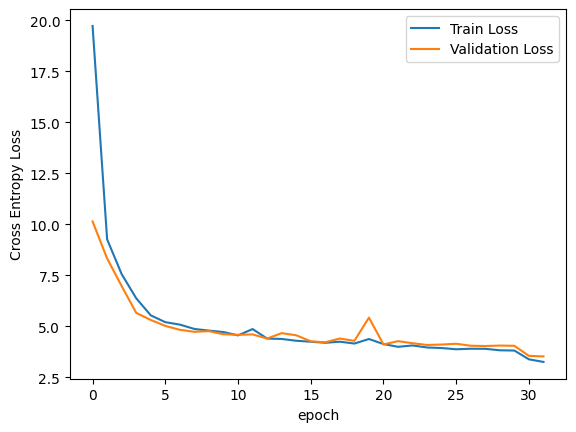

In [35]:
import matplotlib.pyplot as plt
import os
  

    
# plt_numlayer = "{}{}".format("No. layers=", NUM_LAYERS)
# plt_channel = "{}{}".format("hidden channels=", HIDDEN_CHANNELS)
# plt_mlp = "{}{}".format("mlpout=", MLP_OUTPUT_SIZE)
# plt_step = "{}{}".format("step=", STEP_SIZE)

# plt_filename = "{}{}{}{}".format("L", NUM_LAYERS, "C", HIDDEN_CHANNELS)


plt.plot(lst_tr_loss, label="Train Loss")
plt.plot(lst_vl_loss, label="Validation Loss")

plt.xlabel('epoch')
plt.ylabel('Cross Entropy Loss')
#plt.ylabel('Focal Loss')


plt.legend()
#plt.savefig("loss_weighted_message_passing_BCE_Jan25_32epochs_4block.png")
#plt.savefig("figures_Oct/"+file_batch+"/loss_"+plt_filename+"_2cores_norm"+".png")

plt.show()

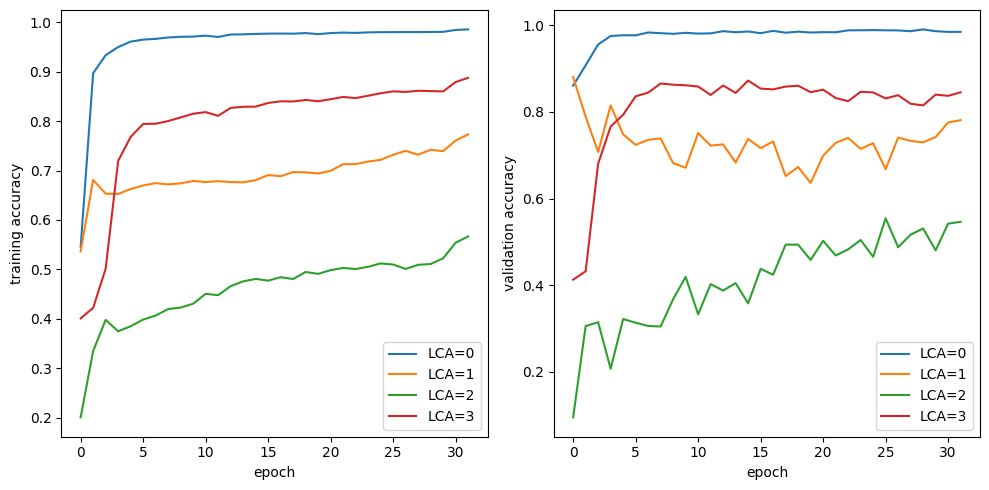

In [36]:
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
# fig.suptitle(plt_numlayer +', '+ plt_channel+', '+plt_mlp+', '+plt_step, fontsize=14)
# fig.suptitle("without weight, gamma=3")
# fig.suptitle("without weight, gamma=1, " + plt_numlayer +', '+ plt_channel)

# plt.title("with weight, gamma=3")


axarr[0].plot(class1_acc_tr, label="LCA=0")
axarr[0].plot(class2_acc_tr, label="LCA=1")
axarr[0].plot(class3_acc_tr, label="LCA=2")
axarr[0].plot(class4_acc_tr, label="LCA=3")

axarr[0].set_xlabel('epoch')
axarr[0].set_ylabel('training accuracy')

axarr[0].legend()

axarr[1].plot(class1_acc_vl, label="LCA=0")
axarr[1].plot(class2_acc_vl, label="LCA=1")
axarr[1].plot(class3_acc_vl, label="LCA=2")
axarr[1].plot(class4_acc_vl, label="LCA=3")

axarr[1].set_xlabel('epoch')
axarr[1].set_ylabel('validation accuracy')

axarr[1].legend()

fig.tight_layout()
# fig.subplots_adjust(top=0.88)
#plt.savefig("acc_LCAloss_wMP_BCE_32epoch_4block"+".png")


In [38]:
myModel

GNN(
  (_encoder): MLPGraphIndependent(
    (_network): GraphIndependent(
      (_edge_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (_node_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (_global_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
    )
  )
  (_core): MLPGraphNetwork(
    (_network): GraphNetwork(
      (_edge_block): EdgeBlock(
        (_edge_model): MLP(-1, 128, 128, 128, 16)
      )
      (_node_block): NodeBlock(
        (_node_model): MLP(-1, 128, 128, 128, 16)
        (_received_edges_aggregator): EdgesToNodesAggregator()
      )
      (_global_block): GlobalBlock(
        (_global_model): MLP(-1, 128, 128, 128, 16)
        (_edges_aggregator): EdgesToGlobalsAggregator()
        (_nodes_aggregator): NodesToGlobalsAggregator()
      )
      (edge_mlp): MLP(-1, 16, 16, 16, 1)
      (node_mlp): MLP(-1, 16, 16, 16, 1)
      (sigmoid): Sigmoid()
      (s

In [31]:
class1_acc_vl[-1]

tensor(0.9849)

In [32]:
class2_acc_vl[-1]

tensor(0.7950)

In [33]:
class3_acc_vl[-1]

tensor(0.5383)

In [34]:
class4_acc_vl[-1]

tensor(0.8424)

In [42]:
class1_acc_vl[-1]

tensor(0.9853)

In [43]:
class2_acc_vl[-1]

tensor(0.7701)

In [44]:
class3_acc_vl[-1]

tensor(0.5693)

In [45]:
class4_acc_vl[-1]

tensor(0.8123)

In [39]:
class1_acc_vl[-1]

tensor(0.9765)

In [40]:
class2_acc_vl[-1]

tensor(0.7497)

In [41]:
class3_acc_vl[-1]

tensor(0.4104)

In [42]:
class4_acc_vl[-1]

tensor(0.8279)

In [28]:
class1_acc_vl[-1]

tensor(0.9848)

In [29]:
class2_acc_vl[-1]

tensor(0.7886)

In [30]:
class3_acc_vl[-1]

tensor(0.5527)

In [31]:
class4_acc_vl[-1]


tensor(0.8343)

In [54]:
class1_acc_vl[-1]

tensor(0.9840)

In [55]:
class2_acc_vl[-1]

tensor(0.7697)

In [56]:
class3_acc_vl[-1]

tensor(0.5099)

In [57]:
class4_acc_vl[-1]

tensor(0.8342)

In [25]:
class1_acc_vl[-1]

tensor(0.9598)

In [26]:
class2_acc_vl[-1]

tensor(0.7385)

In [27]:
class3_acc_vl[-1]

tensor(0.4841)

In [28]:
class4_acc_vl[-1]

tensor(0.7618)

In [1]:
class1_acc_vl[-1]

NameError: name 'class1_acc_vl' is not defined

In [77]:
class2_acc_vl[-1]

tensor(0.7910)

In [75]:
class3_acc_vl[-1]

tensor(0.5669)

In [76]:
class4_acc_vl[-1]

tensor(0.8175)

In [12]:
myModel.load_state_dict(torch.load('model_8block_32epochs_message_passing_BCE_Jan25.pth'))
myModel.eval()

/tmp/ipykernel_13704/2125270781.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  myModel.load_state_dict(torch.load('model_8block_32epochs_message_passing_BCE_Jan25.pth')

EncodeProcessDecode(
  (_encoder): MLPGraphIndependent(
    (_network): GraphIndependent(
      (_edge_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (_node_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (_global_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
    )
  )
  (_core): MLPGraphNetwork(
    (_network): GraphNetwork(
      (_edge_block): EdgeBlock(
        (_edge_model): MLP(-1, 128, 128, 128, 16)
      )
      (_node_block): NodeBlock(
        (_node_model): MLP(-1, 128, 128, 128, 16)
        (_sent_edges_aggregator): EdgesToNodesAggregator()
      )
      (_global_block): GlobalBlock(
        (_global_model): MLP(-1, 128, 128, 128, 16)
        (_edges_aggregator): EdgesToGlobalsAggregator()
        (_edges_aggregator_max): EdgesToGlobalsAggregator()
        (_edges_aggregator_mean): EdgesToGlobalsAggregator()
        (_edges_aggregator_std): EdgesToGlobalsA

In [29]:
torch.save(myModel.state_dict(), 'model_6block_32epochs_message_passing_BCE_scaled_30Jan25.pth')

In [30]:
class1_acc_tr[-1]

tensor(0.9840)

In [31]:
class2_acc_tr[-1]

tensor(0.7923)

In [32]:
class3_acc_tr[-1]

tensor(0.5790)

In [34]:
class4_acc_tr[-1]

tensor(0.8906)

In [42]:
class1_acc_tr[-1]

tensor(0.9845)

In [43]:
class2_acc_tr[-1]

tensor(0.8000)

In [44]:
class3_acc_tr[-1]

tensor(0.5870)

In [45]:
class4_acc_tr[-1]

tensor(0.8949)

In [46]:
class2_acc_tr

[tensor(0.6118),
 tensor(0.6786),
 tensor(0.6757),
 tensor(0.6558),
 tensor(0.6509),
 tensor(0.6536),
 tensor(0.6666),
 tensor(0.6658),
 tensor(0.6673),
 tensor(0.6685),
 tensor(0.6807),
 tensor(0.6829),
 tensor(0.6897),
 tensor(0.6908),
 tensor(0.6885),
 tensor(0.6641),
 tensor(0.6871),
 tensor(0.7060),
 tensor(0.7084),
 tensor(0.7117),
 tensor(0.7235),
 tensor(0.7219),
 tensor(0.7176),
 tensor(0.7303),
 tensor(0.7269),
 tensor(0.7324),
 tensor(0.7405),
 tensor(0.7406),
 tensor(0.7416),
 tensor(0.7398),
 tensor(0.7685),
 tensor(0.7795),
 tensor(0.7857),
 tensor(0.7923),
 tensor(0.7956),
 tensor(0.8000)]

In [32]:
import pandas

In [33]:
df = pandas.DataFrame({'val_loss' : lst_vl_loss, 'train_loss' : lst_tr_loss, 'val_class1_acc' : [x.item() for x in class1_acc_vl] ,
               'val_class2_acc' : [x.item() for x in class2_acc_vl], 'val_class3_acc' : [x.item() for x in class3_acc_vl], 
                  'val_class4_acc' : [x.item() for x in class4_acc_vl]
                      , 'train_class1_acc' : [x.item() for x in class1_acc_tr] ,
               'train_class2_acc' : [x.item() for x in class2_acc_tr], 'train_class3_acc' : [x.item() for x in class3_acc_tr], 
                  'train_class4_acc' : [x.item() for x in class4_acc_tr]})

In [34]:
df.to_csv("32_epoch_8block_message_passing_BCE_minmax.csv")

In [35]:
myModel.train(False)
vl_loss, vl_acc= eval_one_epoch(epoch_number)

 validation: batch 290 last_batch 290 loss: 3.5355710144700674


In [ ]:
vl_acc

In [36]:
!ls model_8block_32epochs_weighted_message_passing_BCE_Jan25*

model_8block_32epochs_weighted_message_passing_BCE_Jan25.pth


In [62]:
myModel.load_state_dict(torch.load('model_4block_32epochs_message_passing_BCE_Jan25.pth'))
myModel.eval()

/tmp/ipykernel_13704/40802897.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  myModel.load_state_dict(torch.load('model_4block_32epochs_message_passing_BCE_Jan25.pth'))


EncodeProcessDecode(
  (_encoder): MLPGraphIndependent(
    (_network): GraphIndependent(
      (_edge_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (_node_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (_global_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
    )
  )
  (_core): MLPGraphNetwork(
    (_network): GraphNetwork(
      (_edge_block): EdgeBlock(
        (_edge_model): MLP(-1, 128, 128, 128, 16)
      )
      (_node_block): NodeBlock(
        (_node_model): MLP(-1, 128, 128, 128, 16)
        (_sent_edges_aggregator): EdgesToNodesAggregator()
      )
      (_global_block): GlobalBlock(
        (_global_model): MLP(-1, 128, 128, 128, 16)
        (_edges_aggregator): EdgesToGlobalsAggregator()
        (_edges_aggregator_max): EdgesToGlobalsAggregator()
        (_edges_aggregator_mean): EdgesToGlobalsAggregator()
        (_edges_aggregator_std): EdgesToGlobalsA

In [25]:
!ls model*

model_27_epochs_pruning_latest.pth
model_32_epochs_pruning_latest.pth
model_34_6block_epochs_pruning_scattermean.pth
model_4block_32epochs_message_passing_BCE_Jan25.pth
model_4block_32epochs_message_passing_Jan25.pth
model_4block_32epochs_weighted_message_passing_BCE_Jan25.pth
model_4block_32epochs_weighted_message_passing_Jan25.pth
model_6block_32epochs_weighted_message_passing.pth
model_6block_36epochs_weighted_message_passing_full_blocks.pth
model_8block_32epochs_message_passing_BCE_Jan25_new.pth
model_8block_32epochs_message_passing_BCE_Jan25.pth
model_8block_32epochs_no_weighted_message_passing.pth
model_8block_32epochs_weighted_message_passing_BCE_Jan25.pth
model_8block_32epochs_weighted_message_passing_full_graphs.pth
model_8block_32epochs_weighted_message_passing_noBCE.pth
model_8block_32epochs_weighted_message_passing.pth
model_8block_34epochs_weighted_message_passing.pth
model_8block_36epochs_weighted_message_passing.pth
model_time.png
model_time_pruning.png

models:
model_32

In [26]:
myModel.load_state_dict(torch.load('model_8block_32epochs_weighted_message_passing.pth'))
myModel.eval()

/tmp/ipykernel_13704/2343438864.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  myModel.load_state_dict(torch.load('model_8block_32epochs_weighted_message_passing.pth'))

EncodeProcessDecode(
  (_encoder): MLPGraphIndependent(
    (_network): GraphIndependent(
      (_edge_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (_node_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (_global_model): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
    )
  )
  (_core): MLPGraphNetwork(
    (_network): GraphNetwork(
      (_edge_block): EdgeBlock(
        (_edge_model): MLP(-1, 128, 128, 128, 16)
      )
      (_node_block): NodeBlock(
        (_node_model): MLP(-1, 128, 128, 128, 16)
        (_sent_edges_aggregator): EdgesToNodesAggregator()
      )
      (_global_block): GlobalBlock(
        (_global_model): MLP(-1, 128, 128, 128, 16)
        (_edges_aggregator): EdgesToGlobalsAggregator()
        (_edges_aggregator_max): EdgesToGlobalsAggregator()
        (_edges_aggregator_mean): EdgesToGlobalsAggregator()
        (_edges_aggregator_std): EdgesToGlobalsA

In [63]:
for block in  myModel._blocks:
    block._network._node_block._sent_edges_aggregator._weighted = False
    block._network._global_block._edges_aggregator._weighted = False
    block._network._global_block._nodes_aggregator._weighted = False

In [28]:
STEP_SIZE=2

In [54]:
vdata

DataBatch(y=[117026, 4], nodes=[3018, 16], edges=[117026, 16], senders=[117026], receivers=[117026], graph_globals=[32, 16], edgepos=[117026], num_edges=[32], num_nodes=3018, batch=[3018], ptr=[33])

In [64]:
for j, vdata in enumerate(loader_vl): 

    vdata['graph_globals'] = vdata['graph_globals'].unsqueeze(1)
    vdata.receivers = vdata.receivers - torch.min(vdata.receivers)
    vdata.senders = vdata.senders - torch.min(vdata.senders)
    vdata.edgepos = vdata.edgepos - torch.min(vdata.edgepos)
    vdata.to('cuda')
    yBCE_start = 1.*(vdata.y[:,0]==0).unsqueeze(1)
    num_nodes=vdata.nodes.shape[0]
    out = vdata.edges.new_zeros(num_nodes, vdata.edges.shape[1])
    node_sum = scatter_add(vdata.y,vdata.senders,out=out,dim=0)
    ynodes_start = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)
    
    label0 = vdata.y.argmax(dim=1)
    answers = torch.ones_like(vdata.edges).cuda()
    outputs = myModel(vdata, num_processing_steps=STEP_SIZE)
    break

In [58]:
outputs

DataBatch(y=[117026, 4], nodes=[3018, 16], edges=[117026, 4], senders=[117026], receivers=[117026], graph_globals=[32, 16], edgepos=[117026], num_edges=[32], num_nodes=3018, batch=[3018], ptr=[33])

(array([ 0.55159195,  1.10318348,  0.36772783,  0.36772811,  0.36772811,
         0.91931957,  0.73545565,  0.91931957,  0.18386391,  0.1838642 ,
         0.18386391,  0.18386391,  0.        ,  0.1838642 ,  0.36772783,
         0.18386391,  0.55159174,  0.36772783,  0.        ,  0.        ,
         0.55159174,  0.18386391,  0.55159089,  0.        ,  0.36772839,
         0.36772726,  0.36772839,  0.36772839,  0.18386363,  0.36772839,
         0.        ,  0.1838642 ,  0.55159259,  0.18386363,  0.        ,
         0.73545452,  0.36772839,  0.        ,  0.36772726,  0.36772839,
         0.        ,  0.36772839,  0.        ,  0.18386363,  0.55159259,
         0.55159089,  0.1838642 ,  0.55159089,  0.36772726,  0.36772839,
         0.        ,  0.18386306,  0.1838642 ,  0.        ,  0.55159259,
         0.1838642 ,  0.18386306,  0.1838642 ,  0.1838642 ,  0.55159259,
         0.36772839,  0.18386306,  0.55159259,  0.91932099,  0.73545679,
         0.73545679,  0.36772612,  0.        ,  0.9

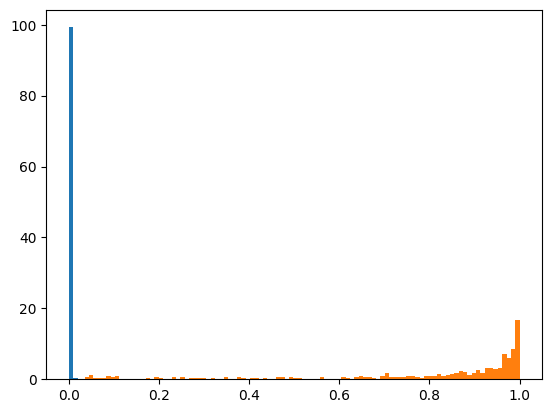

In [65]:
import matplotlib.pyplot as plt

plt.hist(myModel._blocks[3]._network.edge_weights.cpu().detach().numpy()[outputs.cpu().y[:,0] == 1],density=True,bins=100)
plt.hist(myModel._blocks[3]._network.edge_weights.cpu().detach().numpy()[outputs.cpu().y[:,0] != 1],density=True, bins=100)

In [56]:
# myModel._blocks[4]._network.node_prune = True
# myModel._blocks[4]._network.prune_by_cut = True
# myModel._blocks[4]._network.node_weight_cut = 0.01
# myModel._blocks[4]._network.device = 'cuda'
myModel._blocks[5]._network.edge_prune = False
myModel._blocks[5]._network.prune_by_cut = False
myModel._blocks[5]._network.edge_weight_cut = 0.01
myModel._blocks[5]._network.device = 'cuda'
myModel._blocks[3]._network.edge_prune = False
myModel._blocks[3]._network.prune_by_cut = False
myModel._blocks[3]._network.edge_weight_cut = 0.01
myModel._blocks[3]._network.device = 'cuda'
myModel._blocks[7]._network.edge_prune = False
myModel._blocks[7]._network.prune_by_cut = False
myModel._blocks[7]._network.edge_weight_cut = 0.05
myModel._blocks[7]._network.device = 'cuda'
#myModel._blocks[7]._network.node_weight_cut = 0.1
#myModel._blocks[7]._network.edge_weight_cut = 0.1
layer=7

In [44]:
from wmpgnn.util.functions import weight_four_class, acc_four_class

last_batch_vl = len(loader_vl)


def eval_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    acc_one_epoch = []
    
    for j, vdata in enumerate(loader_vl): 

        vdata['graph_globals'] = vdata['graph_globals'].unsqueeze(1)
        vdata.receivers = vdata.receivers - torch.min(vdata.receivers)
        vdata.senders = vdata.senders - torch.min(vdata.senders)
        vdata.edgepos = vdata.edgepos - torch.min(vdata.edgepos)
        vdata.to('cuda')
        yBCE_start = 1.*(vdata.y[:,0]==0).unsqueeze(1)
        num_nodes=vdata.nodes.shape[0]
        out = vdata.edges.new_zeros(num_nodes, vdata.edges.shape[1])
        node_sum = scatter_add(vdata.y,vdata.senders,out=out,dim=0)
        ynodes_start = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)
        
        label0 = vdata.y.argmax(dim=1)
        answers = torch.ones_like(vdata.edges).cuda()
        try:
            outputs = myModel(vdata, num_processing_steps=STEP_SIZE)
        except:
            print("expception ")
            continue
        vdata = outputs
        label= vdata.y.argmax(dim=1)

        num_nodes=vdata.nodes.shape[0]
        out = vdata.edges.new_zeros(num_nodes, vdata.edges.shape[1])
        node_sum = scatter_add(vdata.y,vdata.senders,out=out,dim=0)
        ynodes = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)
#         label= vdata.y
        
        if myModel._blocks[layer]._network.edge_prune == True:
            indices= myModel._blocks[layer]._network.edge_indices
            #indices= myModel._blocks[3]._network.edge_index
            #indices = myModel._blocks[2]._network.edge_node_pruning_indices
            
            #print(label.shape)
            #loss = criterion(outputs.edges, label) 
            index = torch.ones(label0.shape[0], dtype=bool).cuda()
            index[indices] = False
            selected_labels = label0[index]
            answers[:,1:] = 0
            answers[indices] = outputs.edges
            num_nodes=vdata.nodes.shape[0]
            out = vdata.edges.new_zeros(num_nodes, vdata.edges.shape[1])
            node_sum = scatter_add(vdata.y,vdata.senders,out=out,dim=0)
            ynodes = (1.*(torch.sum(node_sum[:,1:],1)>0)).unsqueeze(1)
            # include missing graph 
            #loss += criterion(answers[index], selected_labels)
            yBCE = 1.*(vdata.y[:,0]==0).unsqueeze(1)

        if myModel._blocks[layer]._network.edge_prune == True:
            acc_one_batch = acc_four_class(answers, label0)
        else:
            acc_one_batch = acc_four_class(outputs.edges, label)
        acc_one_epoch.append(acc_one_batch)
#         break
    
    acc_one_epoch=torch.stack(acc_one_epoch)

    return acc_one_epoch.nanmean(dim=0)

In [45]:
myModel.train(False)
myModel.cuda()
STEP_SIZE=2
vl_acc= eval_one_epoch(0)

NameError: name 'gout' is not defined

In [32]:
#weighted mp no cut
vl_acc

tensor([0.9842, 0.7828, 0.5565, 0.8386])

In [36]:
# weighted mp 0.01 3rd block
vl_acc

tensor([0.9888, 0.7765, 0.5523, 0.8282])

In [42]:
# weighted mp 0.1 7th block
vl_acc

tensor([0.9968, 0.7734, 0.5175, 0.7632])

In [46]:
# weighted mp 0.05 7th block
vl_acc

tensor([0.9954, 0.7776, 0.5332, 0.7933])

In [23]:
vl_acc

tensor([0.9900, 0.7763, 0.5608, 0.7821])

In [21]:
vl_acc

tensor([0.9848, 0.7886, 0.5527, 0.8343])

In [1]:
#vl_acc

In [62]:
vl_acc

tensor([0.9909, 0.7897, 0.5580, 0.7877])

In [21]:
vl_acc

tensor([0.9833, 0.7596, 0.5080, 0.8450])

In [33]:
vl_acc

tensor([0.9967, 0.7290, 0.4859, 0.7784])

In [47]:
vl_acc

tensor([0.9884, 0.7506, 0.5112, 0.8395])

In [31]:
myModel._blocks[5].

MLPGraphNetwork(
  (_network): GraphNetwork(
    (_edge_block): EdgeBlock(
      (_edge_model): MLP(-1, 128, 128, 128, 16)
    )
    (_node_block): NodeBlock(
      (_node_model): MLP(-1, 128, 128, 128, 16)
      (_sent_edges_aggregator): EdgesToNodesAggregator()
    )
    (_global_block): GlobalBlock(
      (_global_model): MLP(-1, 128, 128, 128, 16)
      (_edges_aggregator): EdgesToGlobalsAggregator()
      (_nodes_aggregator): NodesToGlobalsAggregator()
    )
    (edge_linear): Linear(in_features=8, out_features=1, bias=True)
    (edge_mlp): MLP(-1, 16, 16, 16, 1)
    (node_linear): Linear(in_features=8, out_features=1, bias=True)
    (node_mlp): MLP(-1, 16, 16, 16, 1)
    (sigmoid): Sigmoid()
    (softmax): Softmax(dim=0)
    (select): SelectTopK(1, ratio=20)
    (select_nodes): SelectTopK(1, ratio=70)
  )
)

In [3]:
!ls 32_epoch_4*.csv

32_epoch_4block_message_passing_BCE_addmeanmax.csv
32_epoch_4block_message_passing_BCE.csv
32_epoch_4block_message_passing_BCE_minmax.csv
32_epoch_4block_message_passing.csv
32_epoch_4block_weighted_message_passing_2.csv
32_epoch_4block_weighted_message_passing_BCE.csv
32_epoch_4block_weighted_message_passing.csv


In [2]:
import pandas

In [188]:
df_nom = pandas.read_csv("32_epoch_no_weighted_message_passing.csv", index_col=0)
df_nowp_BCE = pandas.read_csv("32_epoch__message_passing_BCE.csv", index_col=0)
df_wp_noBCE = pandas.read_csv("32_epoch_weighted_message_passing_noBCE.csv", index_col=0)
df_wp_BCE = pandas.read_csv("32_epoch_weighted_message_passing_BCE.csv", index_col=0)

In [15]:
df_nom = pandas.read_csv("32_epoch_4block_message_passing.csv", index_col=0)
df_nowp_BCE = pandas.read_csv("32_epoch_4block_message_passing_BCE.csv", index_col=0)
df_wp_noBCE = pandas.read_csv("32_epoch_4block_weighted_message_passing_2.csv", index_col=0)
df_wp_BCE = pandas.read_csv("32_epoch_4block_weighted_message_passing_BCE.csv", index_col=0)
df_nowp_BCE_minmax = pandas.read_csv("32_epoch_4block_message_passing_BCE_minmax.csv", index_col=0)

In [21]:
df_nom['Model']='MP'
df_wp_noBCE['Model'] = 'WMP'
df_wp_BCE['Model'] = 'WMP, BCE'
df_nowp_BCE['Model'] = 'MP, BCE'
df_nowp_BCE_minmax['Model'] = 'MP, BCE, agg'

In [22]:
dfconcat = pandas.concat( [df_nom.iloc[-1:,:],df_wp_noBCE.iloc[-1:,:], df_wp_BCE.iloc[-1:,:],  df_nowp_BCE.iloc[-1:,:]])

In [23]:
cols = ['Model','val_class1_acc', 'val_class2_acc',
       'val_class3_acc', 'val_class4_acc'] #, 'train_class1_acc',
      # 'train_class2_acc', 'train_class3_acc', 'train_class4_acc']

In [24]:
df = dfconcat[cols]

In [25]:
df

,Model,val_class1_acc,val_class2_acc,val_class3_acc,val_class4_acc
31,MP,0.959232,0.735833,0.457061,0.794285
31,WMP,0.959166,0.751190,0.495643,0.733849
31,"WMP, BCE",0.983117,0.791396,0.525369,0.830089
31,"MP, BCE",0.985334,0.779036,0.538713,0.814167


In [26]:
renaming = {'val_class2_acc' : 'LCA$_{\\rmtext val}$=1', 'val_class3_acc' : 'LCA$_{\\rmtext val}$=2', 'val_class4_acc' : 'LCA$_{\\rmtext val}$=3', 'val_class1_acc' : 'LCA$_{\\rmtext val}$=1',
           'train_class2_acc' : 'train LCA=1', 'train_class3_acc' : 'train LCA=2', 'train_class4_acc' : 'train LCA=3', 'train_class1_acc' : 'train LCA=0'}

In [27]:
df = df.rename(columns=renaming)

In [28]:

print(df.to_latex(index=False,float_format="{:.3f}".format))

\begin{tabular}{lrrrr}
\toprule
Model & LCA$_{\rmtext val}$=1 & LCA$_{\rmtext val}$=1 & LCA$_{\rmtext val}$=2 & LCA$_{\rmtext val}$=3 \\
\midrule
MP & 0.959 & 0.736 & 0.457 & 0.794 \\
WMP & 0.959 & 0.751 & 0.496 & 0.734 \\
WMP, BCE & 0.983 & 0.791 & 0.525 & 0.830 \\
MP, BCE & 0.985 & 0.779 & 0.539 & 0.814 \\
\bottomrule
\end{tabular}



In [25]:
df.columns

Index(['val_loss', 'train_loss', 'val_class1_acc', 'val_class2_acc',
       'val_class3_acc', 'val_class4_acc', 'train_class1_acc',
       'train_class2_acc', 'train_class3_acc', 'train_class4_acc'],
      dtype='object')

In [32]:
df[['val_class1_acc', 'val_class2_acc',
       'val_class3_acc', 'val_class4_acc', 'train_class1_acc',
       'train_class2_acc', 'train_class3_acc', 'train_class4_acc']]

,val_class1_acc,val_class2_acc,val_class3_acc,val_class4_acc,train_class1_acc,train_class2_acc,train_class3_acc,train_class4_acc
31,0.960,0.739,0.484,0.762,0.961,0.732,0.506,0.821


In [41]:
df.to_latex(float_format="{:.3f}".format)

'\\begin{tabular}{lrrrrrrrrrr}\n\\toprule\n & val_loss & train_loss & val_class1_acc & val_class2_acc & val_class3_acc & val_class4_acc & train_class1_acc & train_class2_acc & train_class3_acc & train_class4_acc \\\\\n\\midrule\n31 & 0.6 & 0.6 & 1.0 & 0.7 & 0.5 & 0.8 & 1.0 & 0.7 & 0.5 & 0.8 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [46]:
!ls 32*csv

32_epoch_4block_message_passing_BCE.csv
32_epoch_4block_message_passing.csv
32_epoch_4block_weighted_message_passing_2.csv
32_epoch_4block_weighted_message_passing.csv
32_epoch__message_passing_BCE.csv
32_epoch_no_weighted_message_passing.csv
32_epoch_weighted_message_passing_BCE.csv
32_epoch_weighted_message_passing_noBCE.csv


In [36]:
df_nom = pandas.read_csv("32_epoch__message_passing_BCE.csv", index_col=0)
#df_nowp_BCE = pandas.read_csv("32_epoch__message_passing_BCE.csv", index_col=0)

In [37]:
df_nom.iloc[-1,:]

val_loss            3.550542
train_loss          3.299775
val_class1_acc      0.984844
val_class2_acc      0.788637
val_class3_acc      0.552709
val_class4_acc      0.834297
train_class1_acc    0.984399
train_class2_acc    0.784322
train_class3_acc    0.569888
train_class4_acc    0.884605
Name: 31, dtype: float64

In [38]:
df.iloc[-1,:]

val_loss            3.535571
train_loss          3.323573
val_class1_acc      0.984728
val_class2_acc      0.794865
val_class3_acc      0.533209
val_class4_acc      0.841544
train_class1_acc    0.984672
train_class2_acc    0.777269
train_class3_acc    0.556378
train_class4_acc    0.873267
Name: 31, dtype: float64